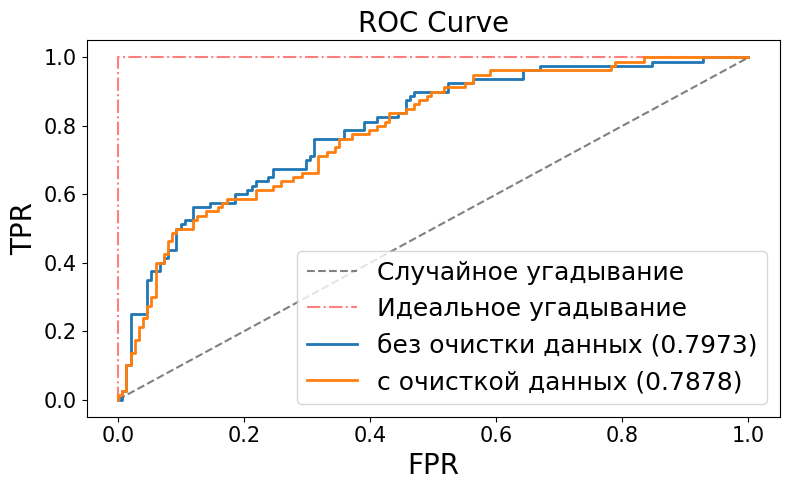

In [2]:
import pandas as pd
# import dtale  # для анализа
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

from tools_plot import get_plot_roc

def get_df(prepare=True):
    df = pd.read_csv('diabetes.csv')
    
    if prepare:
        # заполняем нули в колонках на наиболее вероятные значения
        if 1:
            for column in df.columns:
                if column == 'Pregnancies':
                    continue
                if column == 'Outcome':
                    continue
                df.loc[df[column]==0, column] = None

            modes = df.mode()[:1].squeeze(axis=0)
            df.fillna(modes, inplace=True)

        # Обрежем выбросы до разумных значений
        df.loc[df['SkinThickness'] > 63, 'SkinThickness'] = 63
        df.loc[df['Insulin'] > 630, 'Insulin'] = 630
        df.loc[df['BMI'] > 55, 'BMI'] = 55
        df.loc[df['DiabetesPedigreeFunction'] > 1.5, 'DiabetesPedigreeFunction'] = 1.5
        df.loc[df['Age'] > 63, 'Age'] = 63

        # Делаем нормализацию
        for column in df.columns:
            if column == 'Outcome':
                continue
            m = df[column].max()
            df[column] = df[column] / m

        # удалить столбцы, которые оказывают наименьшее влияние на результат.
        # Для этого сделаем функцию оценки влияния:
        from sklearn.feature_selection import mutual_info_regression
        def make_mi_scores(X, y, discrete_features='auto'):
            if isinstance(X, pd.Series):
                X = pd.DataFrame(X)
            mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
            mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
            mi_scores = mi_scores.sort_values(ascending=False)
            return mi_scores
        # Передадим в эту функцию все столбцы, чтобы определить наиболее
        df_scores = []
        for col in df.columns:
            if 'Outcome' in col:
                continue
            df_scores.append(make_mi_scores(df[col], df['Outcome']))
        df_scores = pd.concat(df_scores)
        df_scores.sort_values(ascending=False)
        # В результате получим таблицу, в которой будет оценка влияния
        # столбцов набора данных на результат. Обрежем самые мало влияющие,
        # к примеру, которые со значением меньше 0.005
        df = df.drop(labels=df_scores[df_scores < 0.005].index.to_list(), axis=1)
            
    return df


# Без очистки данных
df = get_df(False)
X = df.copy()
y = X.pop('Outcome')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred1 = lr.predict(X_valid)
plot, fig, ax, score1 = get_plot_roc(y_valid, y_pred1, pos_label=1, title_plot='Лог.регр', title_line='без очистки данных')

# С очисткой данных
df = get_df(True)
X = df.copy()
y = X.pop('Outcome')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred2 = lr.predict(X_valid)
plot2, fig, ax, score2 = get_plot_roc(y_valid, y_pred2, pos_label=1, title_line='с очисткой данных', plot=plot, fig=fig, ax=ax)
plot2.show()

### Нет большого смысла очищать и нормировать эти данные. Датасет можно использовать в сыром виде